In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
import fbprophet
from fbprophet import Prophet

In [32]:
df = pd.read_csv('google-data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [33]:
df.info

<bound method DataFrame.info of             Date         Open         High          Low        Close  \
0     2013-01-02   357.385559   361.151062   355.959839   359.288177   
1     2013-01-03   360.122742   363.600128   358.031342   359.496826   
2     2013-01-04   362.313507   368.339294   361.488861   366.600616   
3     2013-01-07   365.348755   367.301056   362.929504   365.001007   
4     2013-01-08   365.393463   365.771027   359.874359   364.280701   
...          ...          ...          ...          ...          ...   
1254  2017-12-22  1061.109985  1064.199951  1059.439941  1060.119995   
1255  2017-12-26  1058.069946  1060.119995  1050.199951  1056.739990   
1256  2017-12-27  1057.390015  1058.369995  1048.050049  1049.369995   
1257  2017-12-28  1051.599976  1054.750000  1044.770020  1048.140015   
1258  2017-12-29  1046.719971  1049.699951  1044.900024  1046.400024   

        Adj Close   Volume  
0      359.288177  5115500  
1      359.496826  4666500  
2      366.60061

In [34]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [35]:
df=df[['Date','Close']]
df=df.sort_values("Date")
df.head()

,Date,Close
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


In [36]:
df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
df.head()

,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


In [37]:
df.ds.min()

'2013-01-02'

In [38]:
df.ds.max()

'2017-12-29'

In [39]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
future_data = model.make_future_dataframe(periods=100, freq='D')
preds1 = model.predict(future_data)

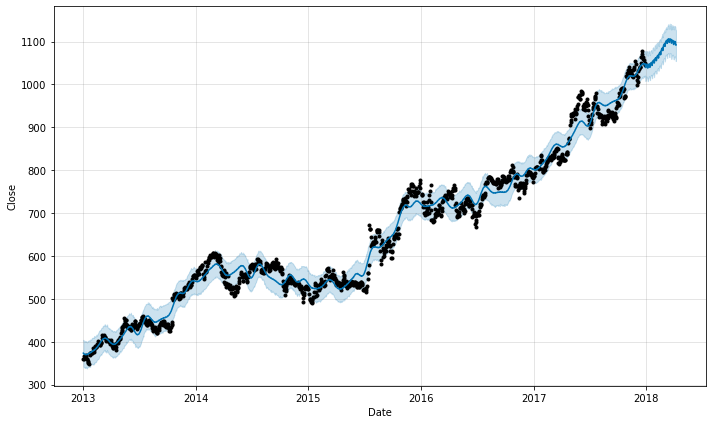

<Figure size 1296x432 with 0 Axes>

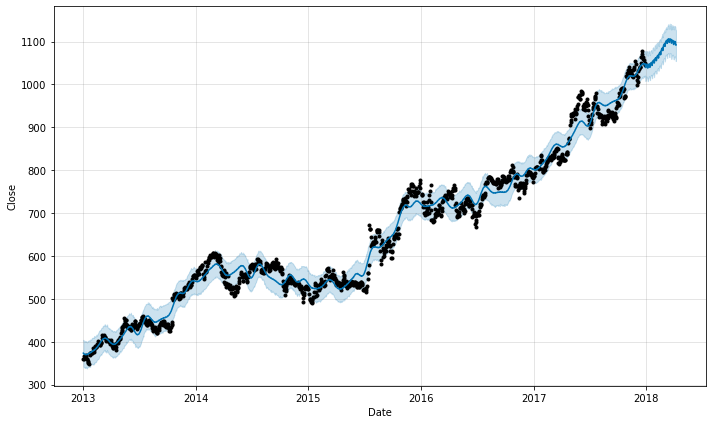

In [41]:
plt.figure(figsize=(18, 6))
model.plot(preds1, xlabel = 'Date', ylabel = 'Close')

# bayesian optimization

In [14]:
!pip install scikit-optimize

In [15]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [16]:
df.shape

(1259, 2)

Cross-validation haqqında [buradan](https://facebook.github.io/prophet/docs/diagnostics.html) oxuyub parametrlərini anlayın və öz tapşırığıza uyğun halda yazın

In [19]:
df_cv = cross_validation(model, initial='1000 days', period='180 days', horizon = '365 days')
    
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


In [20]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,3315.010676,57.576129,44.369647,0.060875,0.034740,0.400000
1,38 days,3590.036917,59.916917,46.025090,0.063312,0.035029,0.386667
2,39 days,3834.796750,61.925736,47.071785,0.064849,0.034740,0.400000
3,40 days,3780.194252,61.483284,46.549804,0.063998,0.034582,0.413333
4,41 days,3792.524983,61.583480,46.923696,0.064400,0.034582,0.413333
...,...,...,...,...,...,...,...
324,361 days,58388.714016,241.637567,229.404716,0.260871,0.186272,0.373333
325,362 days,58132.859594,241.107569,228.888911,0.259763,0.186272,0.368889
326,363 days,57356.176415,239.491495,227.160442,0.257094,0.187507,0.373333
327,364 days,57456.413359,239.700675,227.428670,0.257247,0.188432,0.366667


In [21]:
from skopt.space import Real

In [22]:
bounds = [Real(0.001, 0.5,name = 'changepoint_prior_scale'),
          Real(0.01, 10, name = 'seasonality_prior_scale'),
          Real(0.8, 0.95, name = 'changepoint_range'),
          Real(0.01, 10, name = 'holidays_prior_scale')]

In [23]:
from skopt.utils import use_named_args

@use_named_args(bounds)
def objective(**params):
    '''Train a prophet model and return the rmse'''
    # modeling
    m = Prophet(**params)
    
    m.fit(df) 
    df_cv = cross_validation(m, 
                             initial='1000 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
  
    return df_p['rmse'].values[0]

In [24]:
from skopt import gp_minimize

In [25]:
res_gp = gp_minimize(objective, bounds, n_calls=20, random_state=0)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-01-04 00:00:00 and 2016-12-29 00:00:00


In [26]:
best_params = {'changepoint_prior_scale':res_gp.x[0],
               'seasonality_prior_scale' :res_gp.x[1],
               'changepoint_range':res_gp.x[2],
               'holidays_prior_scale':res_gp.x[3]}

In [27]:
best_params

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'changepoint_range': 0.8,
 'holidays_prior_scale': 5.459024099665536}

In [29]:
m = Prophet(**best_params)

m.fit(df)
future_data = m.make_future_dataframe(periods=100, freq='D')
preds = m.predict(future_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


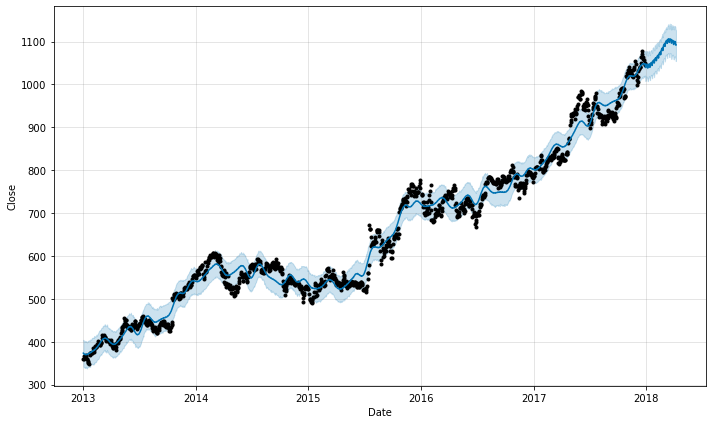

<Figure size 1296x432 with 0 Axes>

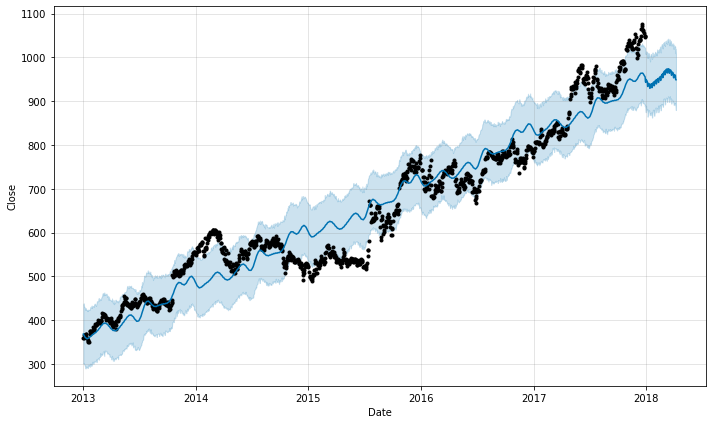

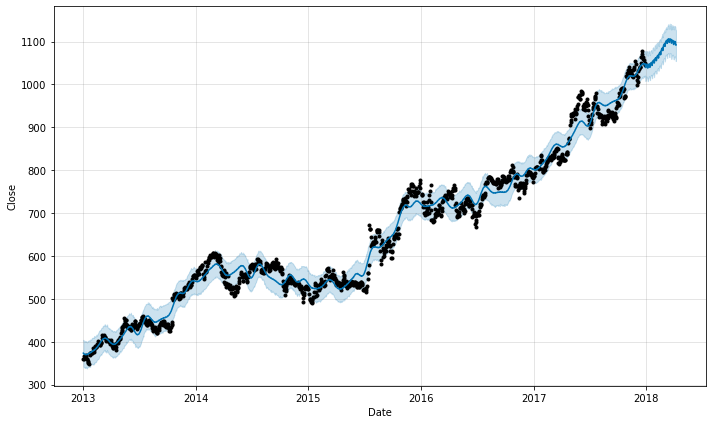

In [42]:
#after bayesian optimization prediction figures goes down, which seems more meaningful
plt.figure(figsize=(18, 6))
model.plot(preds, xlabel = 'Date', ylabel = 'Close')
